## PID

In [1]:
##################################################################################
# Your goal is to follow the comments and complete the the tasks asked of you.
#
# Good luck designing your proportional integral and derivative controller!
#
##################################################################################

class PID_Controller:
    def __init__(self, kp = 0.0, ki = 0.0, kd = 0.0, max_windup = 20,
            start_time = 0, alpha = 1., u_bounds = [float('-inf'), float('inf')]):
        
        # The PID controller can be initalized with a specific kp value
        # ki value, and kd value
        self.kp_ = float(kp)
        self.ki_ = float(ki)
        self.kd_ = float(kd)
        
        # Set max wind up
        self.max_windup_ = float(max_windup)
        
        # Set alpha for derivative filter smoothing factor
        self.alpha = float(alpha) 
        
        # Setting control effort saturation limits
        self.umin = u_bounds[0]
        self.umax = u_bounds[1]

        # Store relevant data
        self.last_timestamp_ = 0.0
        self.set_point_ = 0.0
        self.start_time_ = start_time
        self.error_sum_ = 0.0
        self.last_error_ = 0.0

        # Control effort history
        self.u_p = [0]
        self.u_i = [0]
        self.u_d = [0]

    # Add a reset function to clear the class variables
    def reset(self):
        self.set_point_ = 0.0
        self.kp_ = 0.0
        self.ki_ = 0.0
        self.kd_ = 0.0
        self.error_sum_ = 0.0
        self.last_timestamp_ = 0.0
        self.last_error_ = 0
        self.last_last_error_ = 0
        self.last_windup_ = 0.0

    def setTarget(self, target):
        self.set_point_ = float(target)

    def setKP(self, kp):
        self.kp_ = float(kp)

    def setKI(self, ki):
        self.ki_ = float(ki)

    def setKD(self, kd):
        self.kd_ = float(kd)

    # Create function to set max_windup_
    def setMaxWindup(self, max_windup):
        self.max_windup_ = int(max_windup)

    def update(self, measured_value, timestamp):
        delta_time = timestamp - self.last_timestamp_
        if delta_time == 0:
            # Delta time is zero
            return 0
        
        # Calculate the error 
        error = self.set_point_ - measured_value
        
        # Set the last_timestamp_ 
        self.last_timestamp_ = timestamp

        # Sum the errors
        self.error_sum_ += error * delta_time
        
        # Update the past error
        self.last_error_ = error
        
        # Find delta_error
        delta_error = error - self.last_error_
        
        # Update the past error
        self.last_error_ = error
        
        # Address max windup
        ########################################
        if self.error_sum_ > self.max_windup_:
            self.error_sum_ = self.max_windup_
        elif self.error_sum_ < -self.max_windup_:
            self.error_sum_ = -self.max_windup_
        ########################################
        
        # Proportional error
        p = self.kp_ * error
       
        # Integral error
        i = self.ki_ * self.error_sum_
       
        # Recalculate the derivative error here incorporating 
        # derivative smoothing!
        ########################################
        d = self.kd_ * (self.alpha * delta_error / delta_time + (1 - self.alpha))
        ########################################
        
        # Set the control effort
        u = p + i + d
        
        # Enforce actuator saturation limits
        ########################################
        if u > self.umax:
            u = self.umax
        elif u < self.umin:
            u = self.umin
        ########################################
    
        # Here we are storing the control effort history for post control
        # observations. 
        self.u_p.append(p)
        self.u_i.append(i)
        self.u_d.append(d)

        return u


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pid_controller import PID_Controller

##################################################################################
## DO NOT MODIFY ANY PORTION OF THIS FILE
##################################################################################

def ydot(y, t, pid):
    ''' Returns the state vector at the next time-step

    Parameters:
    ----------
    y(k) = state vector, a length 2 list
      = [altitude, speed]
    t = time, (sec)
    pid = instance of the PIDController class

    Returns
    -------
    y(k+1) = [y[0], y[1]] = y(k) + ydot*dt
    '''

    # Model state
    y0 = y[0] # altitude, (m)
    y1 = y[1] # speed, (m/s)


    # Model parameters
    g = -9.81 # gravity, m/s/s
    m =  1.54 # quadrotor mass, kg
    c =  10.0 # electro-mechanical transmission constant

    # time step, (sec)
    dt = t - pid.last_timestamp_
    # Control effort
    u = pid.update(y0,t)

    ### State derivatives
    # if altitude = 0
    if (y0 <= 0.):
        # if control input, u <= gravity, vehicle stays at rest on the ground
        # this prevents quadrotor from "falling" through the ground when thrust is
        # too small.
        if u <= np.absolute(g*m/c):
            y0dot = 0.
            y1dot = 0.
        else:  # else if u > gravity and quadrotor accelerates upwards
            y0dot = y1
            y1dot = g + c/m*u - 0.75*y1
    else: # otherwise quadrotor is already in the air
        y0dot = y1
        y1dot = g + c/m*u - 0.75*y1

    y0 += y0dot*dt
    y1 += y1dot*dt
    
    # Add some noise to altitude readings
    sigma = 0.1
    y0 = np.random.normal(y0, sigma, 1)
    
    return [y0, y1]


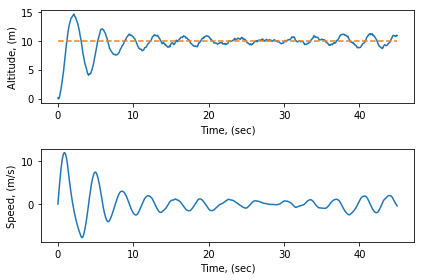

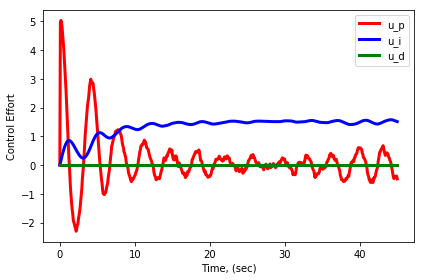

The rise time is 1.202 seconds
The percent overshoot is 46.1%
The steady state offset at 30 seconds is 0.904 meters


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pid_controller import PID_Controller
from quad1d_eom import ydot

##################################################################################
##################################################################################
# This code is what will be executed and what will produce your results
# For this quiz you need to set alpha and umax below to your desired value
# Then modify pid_controller.py to build out your PID controller

kp = 0.5
ki = 0.11
kd = 0.2

umax = 5.0 # max controller output, (N)

alpha = 1.0 # derivative filter smoothing factor

#
# You are encouraged to change them in order to observe the effects
#
# How do the results of this controller differ from that of the last one?
#
##################################################################################
##################################################################################

# Simulation parameters
N = 600 # number of simultion points
t0 = 0  # starting time, (sec)
tf = 45 # end time, (sec)
time = np.linspace(t0, tf, N)
dt = time[1] - time[0] # delta t, (sec)

##################################################################################
# Core simulation code
# Inital conditions (i.e., initial state vector)
y = [0, 0]
   #y[0] = initial altitude, (m)
   #y[1] = initial speed, (m/s)

# Initialize array to store values
soln = np.zeros((len(time),len(y)))

# Create instance of PID_Controller class and 
# initalize and set all the variables
pid = PID_Controller(kp = kp, ki = ki, kd = kd, max_windup = 1e6, u_bounds
        = [0, umax], alpha = alpha)

# Set altitude target
r = 10 # meters
pid.setTarget(r)

# Simulate quadrotor motion
j = 0 # dummy counter
for t in time:
    # Evaluate state at next time point
    y = ydot(y,t,pid)
    # Store results
    soln[j,:] = y
    j += 1

##################################################################################
# Plot results
SP = np.ones_like(time)*r # altitude set point
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(time, soln[:,0],time,SP,'--')
ax1.set_xlabel('Time, (sec)')
ax1.set_ylabel('Altitude, (m)')

ax2 = fig.add_subplot(212)
ax2.plot(time, soln[:,1])
ax2.set_xlabel('Time, (sec)')
ax2.set_ylabel('Speed, (m/s)')
plt.tight_layout()
plt.show()

fig2 = plt.figure()
ax3 = fig2.add_subplot(111)
ax3.plot(time, pid.u_p, label='u_p', linewidth=3, color = 'red')
ax3.plot(time, pid.u_i, label='u_i', linewidth=3, color = 'blue')
ax3.plot(time, pid.u_d, label='u_d', linewidth=3, color = 'green')
ax3.set_xlabel('Time, (sec)')
ax3.set_ylabel('Control Effort')
h, l = ax3.get_legend_handles_labels()
ax3.legend(h, l)
plt.tight_layout()
plt.show()
##################
y0 = soln[:,0] #altitude
rise_time_index =  np.argmax(y0>r)
RT = time[rise_time_index]
print("The rise time is {0:.3f} seconds".format(RT))

OS = (np.max(y0) - r)/r*100
if OS < 0:
    OS = 0
print("The percent overshoot is {0:.1f}%".format(OS))

print ("The steady state offset at 30 seconds is {0:.3f} meters".format(abs(soln[-1,0]-r)))
